In [1]:
import os
from pathlib import Path
SCRIPT_DIR = os.path.dirname(os.path.abspath("__init__.py"))
SRC_DIR = Path(SCRIPT_DIR).parent.absolute()
print(SRC_DIR)

/Users/yannis/PycharmProjects/WeRec3D/src


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import xarray as xr

from data_transformer import extract_stations_from_nc
from data_provider import get_station_indices_map

from taylor_helpers import get_nan_ids, extract_anomalies, get_loo_taylor_metrics
from plotting import create_normed_taylor_diagram

In [4]:
GROUND_TRUTH = "data_sets/ground_truth.nc"
LOO_PRED_FILE_PLAIN = "predictions/loo_pred_plain.nc"
LOO_PRED_FILE_ARM = "predictions/loo_pred_arm.nc"

In [5]:
station_indx_map = get_station_indices_map()
ground_truth = xr.load_dataset(GROUND_TRUTH)
gt_stations = extract_stations_from_nc(ground_truth, station_indx_map)  # Is scaled.
missing_indicies = get_nan_ids(gt_stations)
anomaly_gt_stations = extract_anomalies(gt_stations, station_indx_map, missing_indicies)    # GT has NaNs

# PLAIN
loo_pred_plain = xr.load_dataset(LOO_PRED_FILE_PLAIN)
pred_stations_plain = extract_stations_from_nc(loo_pred_plain, station_indx_map)
anomaly_pred_stations_plain = extract_anomalies(pred_stations_plain, station_indx_map)  
taylor_metrics_plain = get_loo_taylor_metrics(anomaly_gt_stations, anomaly_pred_stations_plain, missing_indicies)



# ARM
loo_pred_arm = xr.load_dataset(LOO_PRED_FILE_ARM)
pred_stations_arm = extract_stations_from_nc(loo_pred_arm, station_indx_map)
anomaly_pred_stations_arm = extract_anomalies(pred_stations_arm, station_indx_map) 
taylor_metrics_arm = get_loo_taylor_metrics(anomaly_gt_stations, anomaly_pred_stations_arm, missing_indicies)

In [9]:
# Verify same order
if not taylor_metrics_arm.keys() == taylor_metrics_plain.keys():
    raise Exception('Order is not the same!')


In [12]:
# markers

# Double-Taylor Plot

In [14]:
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
from mpl_toolkits.axisartist import grid_finder
from mpl_toolkits.axisartist import floating_axes
import numpy as np

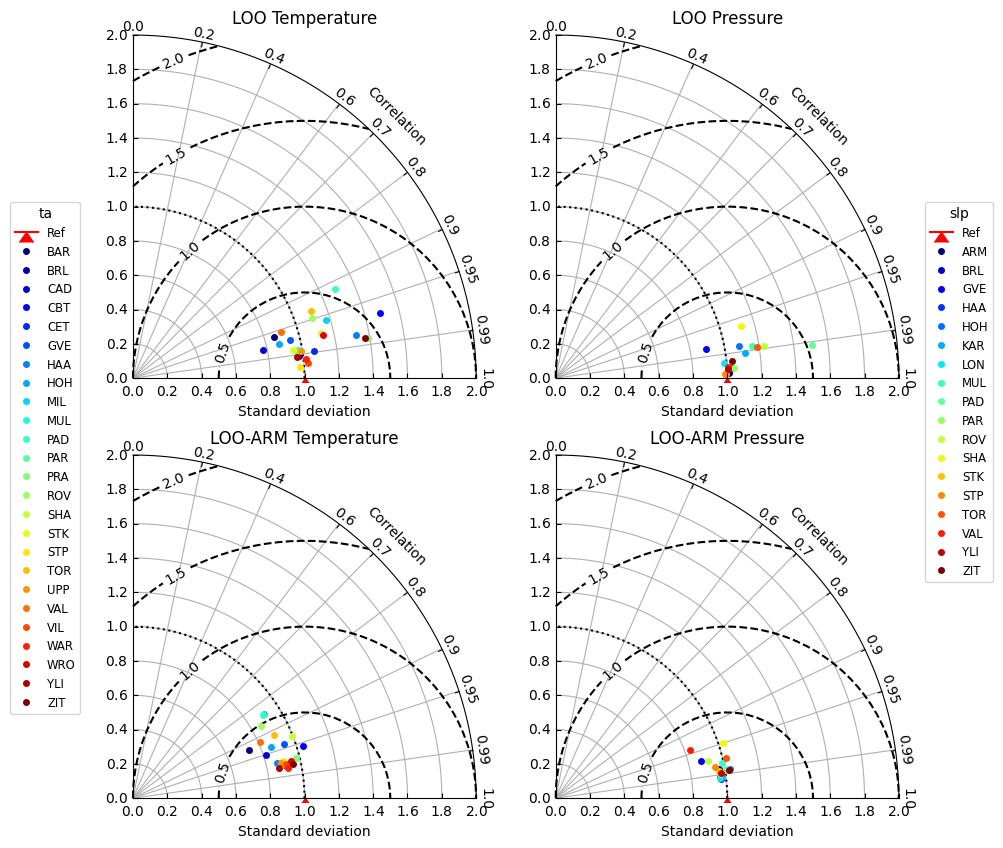

In [97]:
import warnings
warnings.filterwarnings('error')

ref_std = 1
std_axis_min = 0
std_axis_max = 2 * ref_std
markers = ["." if "_ta" in k else "x" for k in taylor_metrics_arm.keys()]


polar_transform = PolarAxes.PolarTransform()
corr_labels = np.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
polar_axis_min = 0
polar_axis_max = np.pi/2
polar_label_locations = np.arccos(corr_labels)
corr_pos_label_mapper = grid_finder.DictFormatter({
        polar_label_locations[i] : str(corr_labels[i]) for i in range(len(corr_labels))
    })
locator = grid_finder.FixedLocator(polar_label_locations)
grid_helper = floating_axes.GridHelperCurveLinear(aux_trans=polar_transform,
                                                  extremes=(polar_axis_min, polar_axis_max,
                                                                std_axis_min, std_axis_max),
                                                      grid_locator1=locator,
                                                      tick_formatter1=corr_pos_label_mapper)

fig = plt.figure(figsize=(10,10))
ax1 = floating_axes.FloatingSubplot(fig, 221, grid_helper=grid_helper)
ax2 = floating_axes.FloatingSubplot(fig, 222, grid_helper=grid_helper)
ax3 = floating_axes.FloatingSubplot(fig, 223, grid_helper=grid_helper)
ax4 = floating_axes.FloatingSubplot(fig, 224, grid_helper=grid_helper)

#      t-plain, p-plain, t-arm, p-arm
axes = [ax1, ax2, ax3, ax4]
include_legend = [False, True]
titles = ["LOO Temperature", "LOO Pressure", "LOO-ARM Temperature", "LOO-ARM Pressure",] # 
var_det = ["_ta", "_slp"]
taylor_metrics = [taylor_metrics_plain, taylor_metrics_arm]

for plt_id in range(len(axes)):
    
    # ta, slp, ta, slp
    _ids = list(map(lambda i: i[0], filter(lambda x: var_det[plt_id%2] in x[1] ,enumerate(taylor_metrics_plain.keys()))))
    metrics = taylor_metrics[plt_id//2] # plain, plain, arm, arm
    
    test_std_devs = [list(metrics.values())[i]['norm_std'] for i in _ids]
    test_corrs = [list(metrics.values())[i]['corr'] for i in _ids]
    labels = [list(metrics.keys())[i].split("_")[0] for i in _ids]
    
    ax = axes[plt_id]
    fig.add_subplot(ax)
    # Add Grid
    ax.grid()
    # Adjust axes
    ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
    ax.axis["top"].toggle(ticklabels=True, label=True)
    ax.axis["top"].major_ticklabels.set_axis_direction("top")
    ax.axis["top"].label.set_axis_direction("top")
    ax.axis["top"].label.set_text("Correlation")

    ax.axis["left"].set_axis_direction("bottom")  # "X axis"
    ax.axis["left"].label.set_text("Standard deviation")

    ax.axis["right"].set_axis_direction("top")    # "Y-axis"
    ax.axis["right"].toggle(ticklabels=True)
    ax.axis["right"].major_ticklabels.set_axis_direction("left")

    ax.axis["bottom"].set_visible(False)

    # Add Reference Point
    polar_ax = ax.get_aux_axes(polar_transform)
    polar_ax.plot(0, ref_std, marker=6, color="r", markersize=10, label="Ref")


    # Add STD-reference line
    std_ref_line_x = np.linspace(0, polar_axis_max)
    std_ref_line_y = np.zeros_like(std_ref_line_x) + ref_std
    polar_ax.plot(std_ref_line_x, std_ref_line_y, 'k:')

    # Add RMSE contour lines
    rmse_a, rmse_b = np.meshgrid(np.linspace(std_axis_min, std_axis_max),
                                 np.linspace(polar_axis_min, polar_axis_max))
    # According to the law of cosine:
    rmse_ = np.sqrt(ref_std**2 + rmse_a**2 - 2*ref_std*rmse_a*np.cos(rmse_b))
    contour_set = polar_ax.contour(rmse_b, rmse_a, rmse_, levels=4, colors='black', linestyles='--')
    plt.clabel(contour_set, inline=1, fontsize=10, colors='black')


    # Plot samples
    nbr_samples = len(test_std_devs)
    colors = plt.matplotlib.cm.jet(np.linspace(0, 1, nbr_samples))
    for i in range(nbr_samples):
        polar_ax.plot(np.arccos(test_corrs[i]), test_std_devs[i], 
                      '.',
                      label=labels[i],
                      color=colors[i],
                      markersize=8)

    plt.title(titles[plt_id])
    
ax1.legend(prop=dict(size='small'), loc='upper right', ncols=1, title="ta",
           bbox_to_anchor=(ax1.get_position().x0 - 0.25, ax1.get_position().y0)  # (x, y, width, height)
           )
ax2.legend(prop=dict(size='small'), loc='upper left', ncols=1, title="slp",
           bbox_to_anchor=(ax2.get_position().x0 + 0.5, ax2.get_position().y0))

plt.savefig(f"figures/plain_arm_comparison.png", 
            bbox_inches='tight',
            pad_inches=0.1)